<a href="https://colab.research.google.com/github/dd-open-source/ml-projects/blob/main/transfer_learning/Ships/Ship_classification_using_transfer_learning_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is our solution for [Analytics Vidhya Hackathon](https://datahack.analyticsvidhya.com/contest/game-of-deep-learning/) using pickle to store all images as single file. This reduced training time from 20 mins to 20 seconds.

In [1]:
# Comment this if you are not running in colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Import Modules

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from os import path, listdir
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import resnet_v2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from google.colab import files
import pickle
import io


### Defines reusable constants

In [3]:
# Data files: 
# Google drive: https://drive.google.com/file/d/1x5XrLOEhiwNO_hJLMFbfdrPQDEymki5z/view
# Download the above data files from our google drive 
# to your google drive or local computer and update the below paths accordingly

project_folder = '/content/drive/MyDrive/ML_Projects/Ships'
data_dir = path.join(project_folder, 'data')
models_path =path.join(project_folder, 'models')
models_dir = path.join(models_path, "base")
train_csv_path = path.join(data_dir, 'train.csv')
test_csv_path = path.join(data_dir, 'test.csv')
label_col = 'category_name'
category_id_col = "category"
image_names_col = 'image'
image_idx_col = 'image_idx'
images_dir = path.join(data_dir, "images")
imgy = imgx = 128
submission_csv_path = path.join(data_dir, 'submission.csv')
categories_name_to_id = {'Cargo': 1,  'Military': 2,  'Carrier': 3, 'Cruise': 4, 'Tankers': 5}
categories_id_to_name = { value:key for key,value in categories_name_to_id.items()}
images_dump_path = path.join(data_dir, 'images.pkl')

Define common functions

In [57]:
from keras_preprocessing.image import dataframe_iterator
def get_image_id(img_name):
    return int(img_name[:-4])

def get_image(img_name, images_dump=None, images_name_to_id=None):
    if images_dump is not None and images_name_to_id is not None:
      img_path = io.BytesIO(images_dump[images_name_to_id[img_name]])
    else:
      img_path = path.join(images_dir, img_name)
    return Image.open(img_path)

# Shows a randomly selected images from data
def showImages(df, n=1, images_dump=None, images_name_to_id=None):
    cols = 5
    rows = max(1, n//cols)
    sample = df.sample(n=n).reset_index(drop=True)
    for idx, row in sample.iterrows():
      img = get_image(row[image_names_col], images_dump, images_name_to_id)
      plt.subplot(rows, cols, idx+1)
      plt.title(row[label_col])
      plt.imshow(img)
    plt.figure(figsize=(10, 20))
    plt.show()


def get_file_bytes(parenet_dir, file_name):
  with open(path.join(parenet_dir, file_name), 'rb') as f:
    return f.read()

def dump_files_as_pickle(parent_dir, dump_file_path):
  if path.exists(dump_file_path):
    print("Dump file exists so skipping")
    return
  file_names = listdir(parent_dir)
  files_dump = []
  for file_name in file_names:
    files_dump.append(get_file_bytes(parent_dir, file_name))

  files_dict = {"parent_dir": parent_dir, "file_names": file_names, "files_dump": files_dump}
  with open(dump_file_path, 'wb') as fh:
    pickle.dump(files_dict, fh)

def create_images_dataset(images_tensor, df):
  def extract_image(img_idx):
    image_string = images_tensor[img_idx]
    img = tf.image.decode_jpeg(image_string, channels=3)
    return tf.image.resize(img, [imgy, imgx], antialias=True)
  ds = tf.data.Dataset.from_tensor_slices(df[image_idx_col])
  return ds.map(extract_image).prefetch(tf.data.AUTOTUNE)

def create_labels_dataset(df):
  one_hot_tensor = tf.one_hot(tf.range(5), 5)
  def convert_label_to_one_hot_tensor(label):
    # Our label index starts with 1
    return one_hot_tensor[label-1]
  label_ds = tf.data.Dataset.from_tensor_slices(df[category_id_col])
  return  label_ds.map(convert_label_to_one_hot_tensor)

def create_dataset_with_labels(images_tensor, df):
  img_ds = create_images_dataset(images_tensor, df)
  label_ds = create_labels_dataset(df)
  return tf.data.Dataset.zip((img_ds, label_ds)).batch(32)

In [5]:
dump_files_as_pickle(images_dir, images_dump_path)

Dump file exists so skipping


### Load data

In [6]:
with open(images_dump_path, "rb") as f:
  images_dump = pickle.load(f)
images_name_to_id = { name:idx for idx, name in enumerate(images_dump['file_names'])}
print("images_dump keys", images_dump.keys(), "\nnum image files", len(images_dump['file_names']))

train_df = pd.read_csv(train_csv_path)
train_df[label_col] = train_df[category_id_col].map(categories_id_to_name)
train_df[image_idx_col] = train_df[image_names_col].map(images_name_to_id)
test_df = pd.read_csv(test_csv_path)
test_df[image_idx_col] = test_df[image_names_col].map(images_name_to_id)

train_df.head()

images_dump keys dict_keys(['parent_dir', 'file_names', 'files_dump']) 
num image files 8932


,image,category,category_name,image_idx
0,2823080.jpg,1,Cargo,3735
1,2870024.jpg,1,Cargo,5246
2,2662125.jpg,2,Military,8426
3,2900420.jpg,3,Carrier,8637
4,2804883.jpg,2,Military,6320


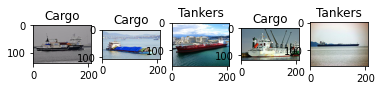

<Figure size 720x1440 with 0 Axes>

In [60]:
showImages(train_df, n=5, images_dump=images_dump['files_dump'], images_name_to_id=images_name_to_id)

Prepare images dump tensors

In [8]:
all_images_tensor = tf.convert_to_tensor(images_dump['files_dump'])

### Prepare datasets for training and validation

In [48]:
train_data, val_data = train_test_split(train_df, test_size=0.2)
train_ds = create_dataset_with_labels(all_images_tensor, train_data)
val_ds = create_dataset_with_labels(all_images_tensor, val_data)
test_ds = create_images_dataset(all_images_tensor, test_df).batch(32)

### Training deep neaural network using Tensorflow

**Transfer learning**: We are using ResNet model for image classification.
1. In 1st phase, we train our model by freezing keeping pre_trained_model (i.e setting trainable=False)
1. In 2nd phase, we train our model by unfreezing keeping pre_trained_model (i.e setting trainable=True) but with very small learning_rate

In [29]:
def create_model(trainable=False):
    pre_trained_model = resnet_v2.ResNet50V2(include_top=False, pooling='max', weights='imagenet', input_shape=(imgy, imgx, 3))
    input = tf.keras.Input(shape=(imgy, imgx, 3))
    output = resnet_v2.preprocess_input(input)
    output = pre_trained_model(output, training=False)
    output = layers.Dropout(0.5)(output)
    output = layers.Dense(5, activation="softmax")(output)
    pre_trained_model.trainable=trainable
    model = tf.keras.Model(input, output)
    return model

def compile_and_fit(model, train_ds, val_ds, model_path, learning_rate=0.01, epochs=5, patience=3, current_best_model=None):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, mode='max')
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_accuracy', factor=0.1, patience=patience,
                                                     mode='max', min_delta=0.0001, cooldown=0, min_lr=min(0.0001, learning_rate))
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_accuracy',
                                                                   mode='max', save_weights_only=True, save_best_only=True)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'], 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    if current_best_model is not None:
      model.set_weights(current_best_model.get_weights())
    train_log = model.fit(train_ds, epochs=epochs, validation_data=val_ds,
                      callbacks=[early_stopping, model_checkpoint_callback, reduce_lr])
    best_model = create_model()
    best_model.load_weights(tf.train.latest_checkpoint(models_dir))
    return best_model, train_log


Fast training phase by freezing the pre-trained-model and followed by 
slow training phase by unfreezing the pre-trained model.

In [31]:
model = create_model()
print(model.summary())
model_path = path.join(models_dir, "best")
print("Fast training phase:")
best_fast_model, train_log = compile_and_fit(model, train_ds, val_ds, model_path, epochs=10, patience=3)
print("Slow training phase:")
best_model, train_log = compile_and_fit(create_model(trainable=True), train_ds, val_ds, model_path, learning_rate=1e-5, 
                                        epochs=20, patience=3, current_best_model=best_fast_model)

Epoch 1/10
157/157 [==============================] - 36s 160ms/step - loss: 0.9116 - accuracy: 0.7281 - val_loss: 0.4082 - val_accuracy: 0.7834 - lr: 1.0000e-05
Epoch 2/10
157/157 [==============================] - 26s 168ms/step - loss: 0.4067 - accuracy: 0.7792 - val_loss: 0.3146 - val_accuracy: 0.7946 - lr: 1.0000e-05
Epoch 3/10
157/157 [==============================] - 20s 125ms/step - loss: 0.2711 - accuracy: 0.8224 - val_loss: 0.2703 - val_accuracy: 0.8082 - lr: 1.0000e-05
Epoch 4/10
157/157 [==============================] - 21s 131ms/step - loss: 0.1851 - accuracy: 0.8700 - val_loss: 0.2651 - val_accuracy: 0.8265 - lr: 1.0000e-05
Epoch 5/10
157/157 [==============================] - 19s 121ms/step - loss: 0.1378 - accuracy: 0.9024 - val_loss: 0.2642 - val_accuracy: 0.8321 - lr: 1.0000e-05
Epoch 6/10
157/157 [==============================] - 26s 168ms/step - loss: 0.1080 - accuracy: 0.9260 - val_loss: 0.2626 - val_accuracy: 0.8401 - lr: 1.0000e-05
Epoch 7/10
157/157 [========

In [32]:
best_fast_model = best_model
best_model, train_log = compile_and_fit(create_model(trainable=True), train_ds, val_ds, model_path, learning_rate=1e-5, 
                                        epochs=10, patience=3, current_best_model=best_fast_model)

Epoch 1/10
157/157 [==============================] - 32s 150ms/step - loss: 0.0443 - accuracy: 0.9722 - val_loss: 0.2632 - val_accuracy: 0.8457 - lr: 1.0000e-05
Epoch 2/10
157/157 [==============================] - 20s 126ms/step - loss: 0.0369 - accuracy: 0.9786 - val_loss: 0.2935 - val_accuracy: 0.8593 - lr: 1.0000e-05
Epoch 3/10
157/157 [==============================] - 20s 128ms/step - loss: 0.0292 - accuracy: 0.9862 - val_loss: 0.2970 - val_accuracy: 0.8633 - lr: 1.0000e-05
Epoch 4/10
157/157 [==============================] - 19s 121ms/step - loss: 0.0283 - accuracy: 0.9874 - val_loss: 0.3059 - val_accuracy: 0.8665 - lr: 1.0000e-05
Epoch 5/10
157/157 [==============================] - 18s 112ms/step - loss: 0.0211 - accuracy: 0.9912 - val_loss: 0.3153 - val_accuracy: 0.8553 - lr: 1.0000e-05
Epoch 6/10
157/157 [==============================] - 18s 115ms/step - loss: 0.0187 - accuracy: 0.9912 - val_loss: 0.3354 - val_accuracy: 0.8553 - lr: 1.0000e-05
Epoch 7/10
157/157 [========

#### Check results on test dataset

In [49]:
# Create best model from saved weights
test_predictions = best_model.predict(test_ds)
# Our label index starts with 1
test_df[category_id_col] = pd.Series(np.argmax(test_predictions, axis=1)+1)
test_df[label_col] = test_df[category_id_col].map(categories_id_to_name)

In [50]:
test_df

,image,image_idx,category_name,category
0,1007700.jpg,1452,Cruise,4
1,1011369.jpg,1782,Cruise,4
2,1051155.jpg,1003,Cruise,4
3,1062001.jpg,904,Military,2
4,1069397.jpg,2459,Cruise,4
...,...,...,...,...
2675,950995.jpg,595,Cruise,4
2676,951046.jpg,489,Cruise,4
2677,951323.jpg,912,Cruise,4
2678,952113.jpg,1840,Cargo,1


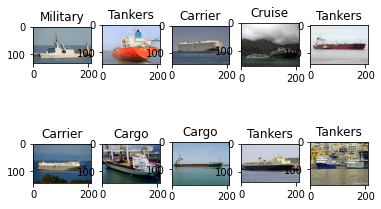

<Figure size 720x1440 with 0 Axes>

In [61]:
showImages(test_df, n=10, images_dump=images_dump['files_dump'], images_name_to_id=images_name_to_id)

**Create Submission file**

In [62]:
test_df[[image_names_col, category_id_col]].to_csv(submission_csv_path, index=False)
files.download(submission_csv_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>